Note: This script should process the main dataset after the normalization script runs over it. This is roughly the final step before converting the datasets into numpy arrays (or using them as dataframes as is if keras takes dataframes as input) for modelling.

1. Imports

In [1]:
from replica_processor import *
import random

Welcome to JupyROOT 6.24/06


2. Load the main dataset

In [2]:
df = pd.read_csv('normed_anoms2.csv', dtype={'x':'int8','y':'int8','ftag_id':'int8','occ':'float32','hist_type':'int8','hist_id':'int16','quality':'int8','occ_0to1':'float32','occ_zscore':'float32','occ_robust':'float32'})
df

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0,3872943.0,0,0,0,1,0.084320,3.641077,1.564232
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1,4551316.0,0,0,0,1,0.099089,4.307510,1.903885
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2,0.0,0,0,0,0,0.000000,-0.163700,-0.374900
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3,3610718.0,0,0,0,1,0.078611,3.383467,1.432940
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4,0.0,0,0,0,0,0.000000,-0.163700,-0.374900
...,...,...,...,...,...,...,...,...,...,...,...
41235475,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,60,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235476,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,61,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235477,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,62,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235478,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,63,78.0,84,17,233,1,0.006434,-0.090692,0.036157


3. Define the processing function 

In [3]:
def full_hist_split(main_dfs,train_set_pct):
    """
    On about 27million datapoints, took only 6-7mins
    
    Example Use:
        x_train,x_test = full_hist_split(main_dfs,.67)
    """
    
    try:
        del x_train_df
        del x_test_df
    except:
        pass

    for idf,ftid in enumerate(main_dfs['ftag_id'].unique()):

        # Progress
        progress_bar(idf,main_dfs['ftag_id'].unique())

        # Initialize randomized hist index lists
        rand_train_list = []
        rand_test_list = []

        print('setting up mask1 datapoints...')
        mask1 = main_dfs['ftag_id'] == ftid
        tmp = main_dfs.loc[mask1,:]

        # Gen rand_train_list for train_set
        print('generating rand_list...')
        while len(rand_train_list) < round(train_set_pct*len(tmp['hist_id'].unique())):
            rand_num = random.randint(0,len(tmp['hist_id'].unique())-1)
            if rand_num in rand_train_list:
                continue
            rand_train_list.append(rand_num)

        # Gen rand_test_list for train_set
        while len(rand_test_list) < round((1-train_set_pct)*len(tmp['hist_id'].unique())):
            rand_num = random.randint(0,len(tmp['hist_id'].unique())-1)
            if rand_num in rand_train_list or rand_num in rand_test_list:
                continue
            rand_test_list.append(rand_num)

        # Build the training set
        
        print('setting up mask2 datapoints...')
        mask2 = tmp['hist_id'].isin(rand_train_list)
        tmp2 = tmp.loc[mask2,:]
        
        print('updating dataframe...')
        try:
            x_train_df = pd.concat([x_train_df,tmp2])
        except:
            x_train_df = tmp2

        # Build the test set
        
        print('setting up mask2 datapoints...')
        mask2 = tmp['hist_id'].isin(rand_test_list)
        tmp2 = tmp.loc[mask2,:]
        
        print('updating dataframe...')
        try:
            x_test_df = pd.concat([x_test_df,tmp2])
        except:
            x_test_df = tmp2
            
    return x_train_df, x_test_df

4. split the hists with the function and set parameters

In [4]:
x_train_df,x_test_df = full_hist_split(df,.67)

Processing file 83 of 83 files... 100.0% Complete
setting up mask1 datapoints...
generating rand_list...
setting up mask2 datapoints...
updating dataframe...
setting up mask2 datapoints...
updating dataframe...


5. View and verify the result

In [5]:
x_train_df['quality'].value_counts()

0    21501056
1     6092224
Name: quality, dtype: int64

In [6]:
x_test_df['quality'].value_counts()

0    10587865
1     3054335
Name: quality, dtype: int64

In [7]:
# How many histograms do we have that are invalid (all occ values are 0)
cnt=0
for ftag in x_train_df['ftag_id'].unique():
    tmp = x_train_df[x_train_df['ftag_id']==ftag]
    for histid in x_train_df[x_train_df['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        if len(tmp2['occ'].value_counts().values)==1:
            cnt+=1
#             print(ftag,histid)
#             input_heatmap(x_train_noanom_df,ftag,histid)
#             plt.show()
cnt

69

In [8]:
# How many histograms do we have that are invalid (all occ values are 0) for the test set
cnt=0
for ftag in x_test_df['ftag_id'].unique():
    tmp = x_test_df[x_test_df['ftag_id']==ftag]
    for histid in x_test_df[x_test_df['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        if len(tmp2['occ'].value_counts().values)==1:
            cnt+=1
#             print(ftag,histid)
#             input_heatmap(x_train_noanom_df,ftag,histid)
#             plt.show()
cnt

27

In [9]:
# How many histograms total do we have in this dataset
cnt=0
for ftag in df['ftag_id'].unique():
    tmp = df[df['ftag_id']==ftag]
    for histid in tmp[tmp['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        cnt+=1
cnt

6408

In [10]:
def input_heatmap(df,ftag_id,hist_id):
    tmp = df[df['ftag_id']==ftag_id]
    tmp = tmp[tmp['hist_id']==hist_id]
    sns.heatmap( tmp.pivot_table(index='y',columns='x',values='occ') )

<IPython.core.display.Javascript object>

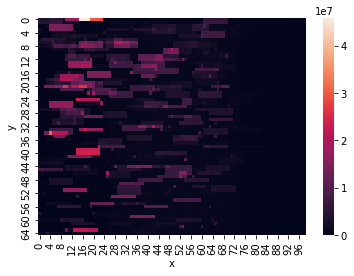

In [12]:
input_heatmap(x_test_df,0,0)

6. Save results

In [13]:
x_train_df.to_csv('x_train_df2.csv',index=False)
x_test_df.to_csv('x_test_df2.csv',index=False)